##### Import the libraries

In [1]:
import os
import json
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.ops import box_iou
from torchvision.ops import nms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_recall_fscore_support
import rich
from PIL import Image, ImageDraw
from segmentation_models_pytorch import Unet
import numpy as np
from tqdm import tqdm
from itertools import product

##### Predefined parameters

In [2]:
image_new_dimension = 256
batch_size = 2
threshold = 0.5

##### Transform to tensor

In [3]:
class FacadeDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [file for file in os.listdir(image_dir) if file.endswith('.jpg')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = f"mask_{os.path.splitext(img_name)[0]}.png"
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


# Define transformations
transform = transforms.Compose([
    transforms.Resize((image_new_dimension, image_new_dimension)),
    transforms.ToTensor()
])

# Directories for training
train_image_dir = os.path.join("ZJU_dataset_2", "images")
train_masks_dir = os.path.join("ZJU_dataset_2", "masks")

# Directories for training
# train_image_dir = os.path.join("ZJU_dataset_2_full", "images")
# train_masks_dir = os.path.join("ZJU_dataset_2_full", "masks")

# Create dataset
dataset = FacadeDataset(train_image_dir, train_masks_dir, transform=transform)

# print("Dataset :", dataset[0])

print("Dataset length:", len(dataset))

Dataset length: 216


##### Split the dataset

In [4]:
# Define the proportions for train, validation, and test
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Load the full dataset (assuming train_annotations includes all data at this stage)
full_dataset = FacadeDataset(train_image_dir, train_masks_dir, transform=transform)

# Calculate lengths of each split
train_size = int(train_ratio * len(full_dataset))
val_size = int(val_ratio * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 151
Validation dataset size: 43
Test dataset size: 22


##### Prepare Data Loaders

In [5]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Train dataset:", len(train_dataset))
print("Validation dataset:", len(val_dataset))
print("Test dataset:", len(test_dataset))

Train dataset: 151
Validation dataset: 43
Test dataset: 22


##### Checking the input data

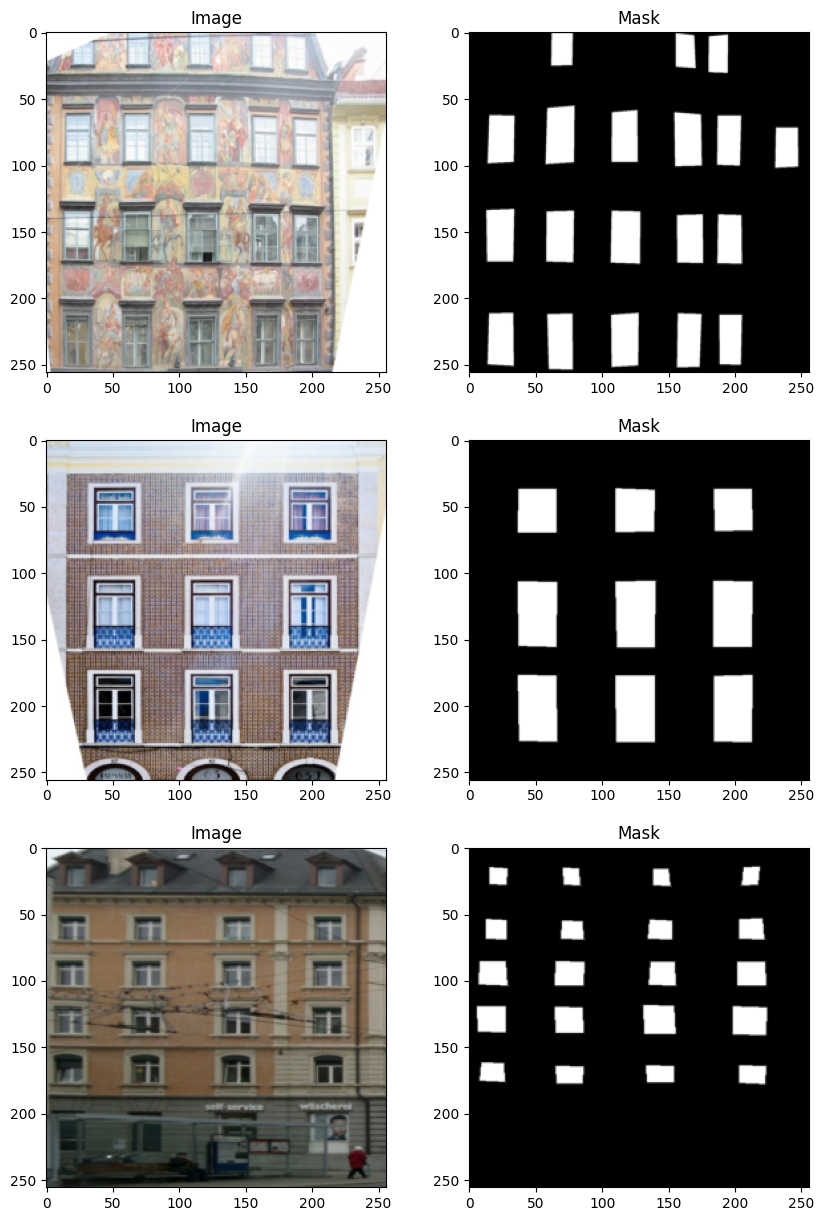

In [6]:
# Visualize some samples
def visualize_samples(dataset, num_samples=3):
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    for i in range(num_samples):
        image, mask = dataset[i]
        axs[i, 0].imshow(image.permute(1, 2, 0))  # assuming image is in (C, H, W) format and needs permute to (H, W, C)
        axs[i, 0].set_title('Image')
        axs[i, 1].imshow(mask.squeeze(), cmap='gray')  # squeeze to remove single channel dimension
        axs[i, 1].set_title('Mask')
    plt.show()

visualize_samples(train_dataset)


##### Define The Model

In [7]:
# Initialize U-Net model
model = Unet(encoder_name="resnet34",        # Choose encoder architecture
             encoder_weights="imagenet",    # Use pre-trained weights
             in_channels=3,                 # Input channels (RGB)
             classes=1)                     # Output channels (binary segmentation)

##### Check if Cuda is avaliable and what GPU does it use

In [8]:
# Check if CUDA is available and print the device being used
if torch.cuda.is_available():
    print("CUDA is available. Using GPU:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU: NVIDIA GeForce GTX 1660 Ti


##### Hayper parameters tunning

In [9]:
def find_best_hyperparameters_segmentation(
    model, 
    train_loader, 
    val_loader, 
    param_grid, 
    device='cuda', 
    num_epochs=5
):
    """
    Find the best hyperparameters for the segmentation model using grid search.
    
    Parameters:
        model: The model to be trained and evaluated.
        train_loader: DataLoader for the training set.
        val_loader: DataLoader for the validation set.
        param_grid: Dictionary of hyperparameters to search. Example:
                    {
                        'lr': [0.0001, 0.001],
                        'weight_decay': [0.0001, 0.001]
                    }
        device: Device to use ('cuda' or 'cpu').
        num_epochs: Number of epochs for each hyperparameter combination.
    
    Returns:
        A dictionary with the best hyperparameters and their corresponding metrics.
    """

    criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss with logits
    best_params = None
    best_metrics = None

    # Generate all combinations of hyperparameters
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]

    for params in param_combinations:
        print(f"Testing hyperparameters: {params}")

        # Update optimizer
        optimizer = optim.Adam(
            model.parameters(), 
            lr=params['lr'], 
            weight_decay=params.get('weight_decay', 0.0)
        )
        
        # Training loop
        model = model.to(device)
        for epoch in range(num_epochs):
            model.train()
            for images, masks in train_loader:
                images, masks = images.to(device), masks.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()

        # Validation loop
        model.eval()
        with torch.no_grad():
            total_iou, total_precision, total_recall, total_f1 = 0, 0, 0, 0
            num_batches = 0

            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                preds = torch.sigmoid(outputs) > threshold  # Threshold predictions at 0.5

                # Flatten predictions and masks for metric calculation
                preds_flat = preds.view(-1)
                masks_flat = masks.view(-1).bool()

                # # IoU
                # intersection = (preds_flat & masks_flat).sum().item()
                # union = (preds_flat | masks_flat).sum().item()
                # iou = intersection / union if union > 0 else 0
                # total_iou += iou

                # Precision, Recall, F1-Score
                tp = (preds_flat & masks_flat).sum().item()
                fp = (preds_flat & ~masks_flat).sum().item()
                fn = (~preds_flat & masks_flat).sum().item()

                iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

                total_iou += iou
                total_precision += precision
                total_recall += recall
                total_f1 += f1
                num_batches += 1

            # Mean metrics over validation set
            mean_iou = total_iou / num_batches
            mean_precision = total_precision / num_batches
            mean_recall = total_recall / num_batches
            mean_f1 = total_f1 / num_batches

        metrics = {
            'mean_iou': mean_iou,
            'precision': mean_precision,
            'recall': mean_recall,
            'f1': mean_f1
        }

        print(f"Metrics for {params}: {metrics}")

        if best_metrics is None or metrics['f1'] > best_metrics['f1']:
            best_params = params
            best_metrics = metrics

    print(f"Best hyperparameters: {best_params}")
    print(f"Best metrics: {best_metrics}")
    return {'best_params': best_params, 'best_metrics': best_metrics}


In [ ]:
'''
param_grid = {
    'lr': [0.0001, 0.001],
    'weight_decay': [0.0001, 0.001]
}
num_epochs=5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_hyperparams = find_best_hyperparameters_segmentation(model, train_loader, val_loader, param_grid, device=device, num_epochs=num_epochs)
'''

##### early stopping functions

In [10]:
# Taken from https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.epoch = 0
        self.trace_func = trace_func
    def __call__(self, val_loss, epoch, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.epoch = epoch
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.epoch = epoch
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [11]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

##### train and evaluate the model

In [13]:
NUM_EPOCHS = 2

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.95, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss

Training:   4%|▍         | 3/76 [00:03<01:05,  1.11it/s]

Epoch: 0 Batch Index: 0 Loss: 1.1136081218719482


Training:  70%|██████▉   | 53/76 [00:06<00:01, 18.70it/s]

Epoch: 0 Batch Index: 50 Loss: 0.20309767127037048


Validation Metrics - Epoch [1/2]
  Mean IoU: 0.3961
  Precision: 0.6616
  Recall: 0.5142
  F1 Score: 0.5524
Epoch #0 TRAIN LOSS: 0.41175784523549835 VALIDATION LOSS: 0.2546799338676713

Validation loss decreased (inf --> 0.254680).  Saving model ...


Training:   3%|▎         | 2/76 [00:00<00:04, 17.10it/s]

Epoch: 1 Batch Index: 0 Loss: 0.3443542718887329


Training:  70%|██████▉   | 53/76 [00:02<00:01, 18.39it/s]

Epoch: 1 Batch Index: 50 Loss: 0.20938125252723694


Validation Metrics - Epoch [2/2]
  Mean IoU: 0.4401
  Precision: 0.7774
  Recall: 0.5267
  F1 Score: 0.5926
Epoch #1 TRAIN LOSS: 0.22074789122531288 VALIDATION LOSS: 0.188143675300208

Validation loss decreased (0.254680 --> 0.188144).  Saving model ...


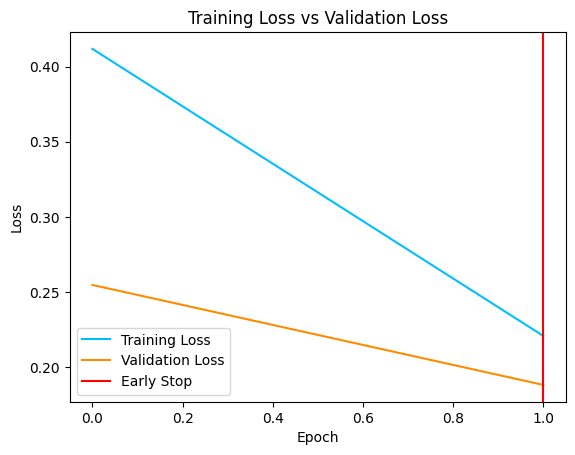

Training finished!


In [14]:
train_losses = Averager()
totalTrainLosses = []
val_losses = Averager()
totalValLosses = []
lowest_val_loss = float('inf')
early_stopping = EarlyStopping(patience = 3, path = "checkpoint.pth", verbose=True)
# has to be in train mode for both train and valid coz the outputs are different in two cases
for epoch in range(NUM_EPOCHS):
    train_losses.reset()
    val_losses.reset()
    model.train()
    # Progress bar for the training loop
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for batch_index, (images, masks) in enumerate(train_loader_tqdm):
        # move the images and targets to device
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        outputs = model(images)
        loss = criterion(outputs, masks)
        # track the loss
        train_losses.send(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 50 == 0:
            print(f"Epoch: {epoch} Batch Index: {batch_index} Loss: {loss.item()}")

    # evaluate
    model.train()
    with torch.no_grad():
        # Progress bar for the validation loop
        val_loader_tqdm = tqdm(val_loader, desc="Validating loss", leave=False)
        for _, (images, masks) in enumerate(val_loader_tqdm):
            # move the images and targets to device

            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            outputs = model(images)
            val_loss = criterion(outputs, masks)

            # track the loss
            val_losses.send(val_loss.item())

    # Metric Evaluation
    model.eval()
    with torch.no_grad():
        val_loader_tqdm = tqdm(val_loader, desc="Validating Metrics", leave=False)
        all_precisions, all_recalls, all_f1s, all_ious = [], [], [], []
        for _, (images, masks) in enumerate(val_loader_tqdm):

            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            
            # Get predictions
            outputs = model(images)

            preds = torch.sigmoid(outputs) > threshold  # Threshold predictions at 0.5

            # Flatten predictions and masks for metric calculation
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1).bool()
            
            # Calculate precision, recall, F1 at IoU 0.5 threshold
            # Precision, Recall, F1-Score
            tp = (preds_flat & masks_flat).sum().item()
            fp = (preds_flat & ~masks_flat).sum().item()
            fn = (~preds_flat & masks_flat).sum().item()
                    
            iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            all_ious.append(iou)
            all_precisions.append(precision)
            all_recalls.append(recall)
            all_f1s.append(f1)

        # Calculate mean metrics over the entire validation set
        mean_iou = sum(all_ious) / len(all_ious) if all_ious else 0
        mean_precision = sum(all_precisions) / len(all_precisions) if all_precisions else 0
        mean_recall = sum(all_recalls) / len(all_recalls) if all_recalls else 0
        mean_f1 = sum(all_f1s) / len(all_f1s) if all_f1s else 0

        print(f"Validation Metrics - Epoch [{epoch + 1}/{NUM_EPOCHS}]")
        print(f"  Mean IoU: {mean_iou:.4f}")
        print(f"  Precision: {mean_precision:.4f}")
        print(f"  Recall: {mean_recall:.4f}")
        print(f"  F1 Score: {mean_f1:.4f}")

    if val_losses.value >= lowest_val_loss and lr_scheduler is not None:
        lr_scheduler.step()

    # print stats
    print(f"Epoch #{epoch} TRAIN LOSS: {train_losses.value} VALIDATION LOSS: {val_losses.value}\n")
    totalTrainLosses.append(train_losses.value)
    totalValLosses.append(val_losses.value)
    early_stopping(val_losses.value, epoch, model)
    if early_stopping.early_stop:
        print("Early stopping!")
        break

plt.plot(totalTrainLosses, label = "Training Loss", color = "deepskyblue")
plt.plot(totalValLosses, label = "Validation Loss", color = "darkorange")
plt.axvline(early_stopping.epoch, label = "Early Stop", color = "red")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.show()
os.rename("checkpoint.pth", "u_net_checkpoint_2.pth")
print("Training finished!")


##### Visualzing the results (predictions) on the test subset

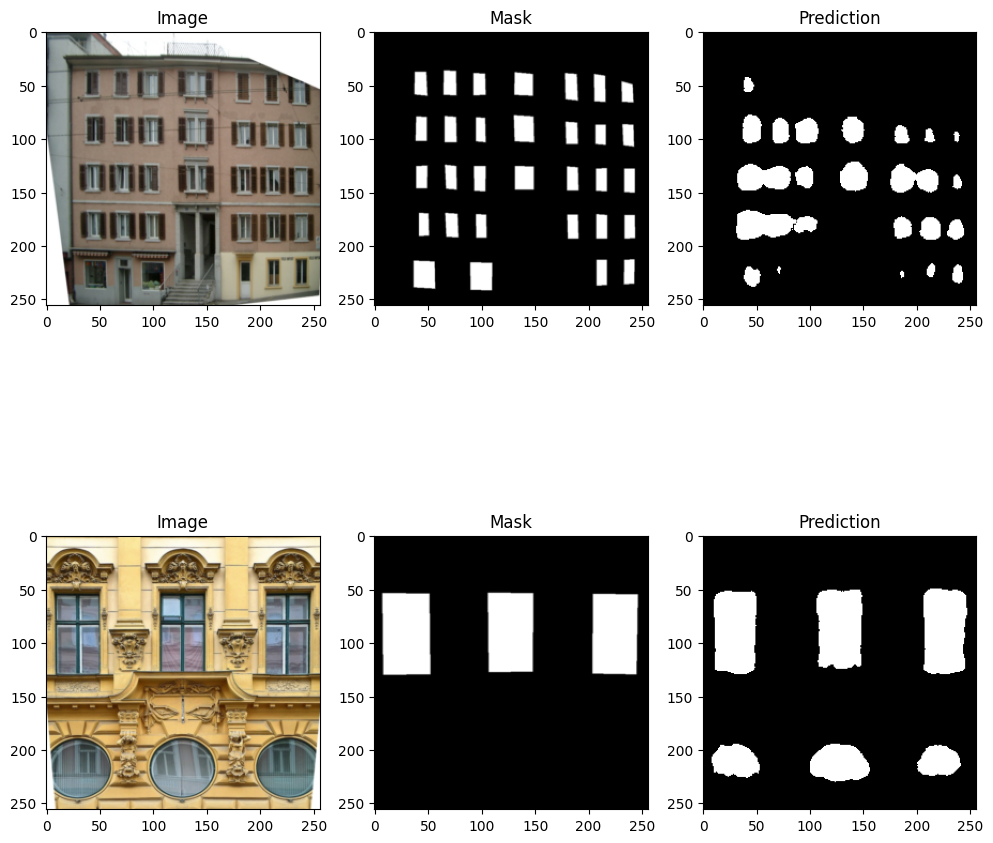

In [15]:
# Get a batch of validation data
images, masks = next(iter(test_loader))
images, masks = images.to(DEVICE), masks.to(DEVICE)

model.eval()
with torch.no_grad():
    outputs = model(images)
    outputs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
    preds = outputs > 0.5  # Threshold to get binary predictions

# Plot some sample images and their predictions
fig, axs = plt.subplots(2, 3, figsize=(12, 12))
for i in range(2):
    axs[i, 0].imshow(images[i].cpu().permute(1, 2, 0))  # Assuming image is in (C, H, W) format
    axs[i, 0].set_title('Image')
    axs[i, 1].imshow(masks[i].cpu().squeeze(), cmap='gray')  # Squeeze to remove single channel dimension
    axs[i, 1].set_title('Mask')
    axs[i, 2].imshow(preds[i].cpu().squeeze(), cmap='gray')  # Squeeze to remove single channel dimension
    axs[i, 2].set_title('Prediction')

plt.show()

##### save and load the model

In [ ]:
'''
# Define the path to save the model
save_path = "unet_checkpoint.pth"

# Save the model and optimizer state dictionaries
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch + 1,  # Save the last completed epoch
}, save_path)

print(f"Model saved to {save_path}")
'''